# Análise de Similaridade de Letras - Engenheiros do Hawaii

Este notebook realiza uma análise completa de similaridade temática entre as letras de músicas dos Engenheiros do Hawaii utilizando técnicas de Processamento de Linguagem Natural (NLP).

## Objetivo
- Gerar embeddings das letras usando sentence-transformers
- Calcular similaridade entre todas as músicas
- Visualizar clusters temáticos
- Identificar músicas mais similares

---

## Seção 0: Instalação Automática de Dependências

Esta seção instala automaticamente todos os pacotes necessários. **Execute esta célula primeiro!**

O notebook detectará quais pacotes estão faltando e os instalará automaticamente.

### ⚠️ IMPORTANTE

- **Primeira execução**: A célula acima pode demorar alguns minutos para instalar todos os pacotes
- **Sentence-transformers**: O pacote `sentence-transformers` é grande (~500MB) e pode demorar para baixar
- **Execuções futuras**: Se os pacotes já estiverem instalados, a célula executará rapidamente
- **Sem internet**: Certifique-se de ter conexão com a internet para baixar os pacotes

---

## Seção 1: Setup e Importações

Importando todas as bibliotecas necessárias para a análise.

In [1]:
import sys
import subprocess
import importlib

def check_and_install(package_name, import_name=None):
    """
    Verifica se um pacote está instalado e instala se necessário.
    
    Args:
        package_name: Nome do pacote no pip
        import_name: Nome usado no import (se diferente do package_name)
    """
    if import_name is None:
        import_name = package_name
    
    try:
        importlib.import_module(import_name)
        print(f"✓ {package_name} já instalado")
        return True
    except ImportError:
        print(f"✗ {package_name} não encontrado. Instalando...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
            print(f"✓ {package_name} instalado com sucesso!")
            return True
        except Exception as e:
            print(f"✗ Erro ao instalar {package_name}: {e}")
            return False

print("="*80)
print("INSTALAÇÃO AUTOMÁTICA DE DEPENDÊNCIAS")
print("="*80)
print("\nVerificando e instalando pacotes necessários...\n")

# Lista de pacotes necessários (package_name, import_name)
required_packages = [
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('beautifulsoup4', 'bs4'),
    ('sentence-transformers', 'sentence_transformers'),
    ('scikit-learn', 'sklearn'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn'),
    ('plotly', 'plotly'),
]

# Pacotes opcionais
optional_packages = [
    ('umap-learn', 'umap'),
    ('networkx', 'networkx'),
]

print("PACOTES OBRIGATÓRIOS:")
print("-"*80)
all_installed = True
for package, import_name in required_packages:
    if not check_and_install(package, import_name):
        all_installed = False

print("\nPACOTES OPCIONAIS (recomendados):")
print("-"*80)
for package, import_name in optional_packages:
    check_and_install(package, import_name)

print("\n" + "="*80)
if all_installed:
    print("✓ TODOS OS PACOTES OBRIGATÓRIOS FORAM INSTALADOS COM SUCESSO!")
    print("\nVocê pode prosseguir para a próxima célula.")
else:
    print("✗ ALGUNS PACOTES NÃO PUDERAM SER INSTALADOS")
    print("\nPor favor, instale-os manualmente usando:")
    print("pip install pandas numpy beautifulsoup4 sentence-transformers scikit-learn matplotlib seaborn plotly")
print("="*80)

INSTALAÇÃO AUTOMÁTICA DE DEPENDÊNCIAS

Verificando e instalando pacotes necessários...

PACOTES OBRIGATÓRIOS:
--------------------------------------------------------------------------------
✓ pandas já instalado
✓ numpy já instalado
✓ beautifulsoup4 já instalado
✗ sentence-transformers não encontrado. Instalando...
✓ sentence-transformers instalado com sucesso!
✓ scikit-learn já instalado
✓ matplotlib já instalado
✓ seaborn já instalado
✗ plotly não encontrado. Instalando...
✓ plotly instalado com sucesso!

PACOTES OPCIONAIS (recomendados):
--------------------------------------------------------------------------------
✗ umap-learn não encontrado. Instalando...
✓ umap-learn instalado com sucesso!
✓ networkx já instalado

✓ TODOS OS PACOTES OBRIGATÓRIOS FORAM INSTALADOS COM SUCESSO!

Você pode prosseguir para a próxima célula.


In [2]:
# Importações básicas
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Processamento de texto
from bs4 import BeautifulSoup
from collections import Counter

# Sentence Transformers para embeddings
from sentence_transformers import SentenceTransformer

# Sklearn para análises e clustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# UMAP para redução dimensional
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP não disponível. Usando t-SNE para redução dimensional.")

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# NetworkX para grafos
try:
    import networkx as nx
    NETWORKX_AVAILABLE = True
except ImportError:
    NETWORKX_AVAILABLE = False
    print("NetworkX não disponível. Visualização de rede será pulada.")

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Todas as bibliotecas importadas com sucesso!")

✓ Todas as bibliotecas importadas com sucesso!


In [3]:
# Verificar versões
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

Pandas: 2.3.3
NumPy: 2.3.5
Matplotlib: 3.10.7
Seaborn: 0.13.2


## Seção 2: Carregamento de Dados

Carregando todos os arquivos CSV da pasta `letras_engenheiros_hawaii` e consolidando em um único DataFrame.

In [4]:
# Definir caminho da pasta com os dados
data_folder = Path('letras_engenheiros_hawaii')

# Verificar se a pasta existe
if not data_folder.exists():
    raise FileNotFoundError(f"Pasta não encontrada: {data_folder}")

# Listar todos os arquivos CSV
csv_files = list(data_folder.glob('*.csv'))
print(f"Encontrados {len(csv_files)} arquivos CSV")
print("\nÁlbuns encontrados:")
for i, file in enumerate(csv_files[:10], 1):
    print(f"{i}. {file.stem}")
if len(csv_files) > 10:
    print(f"... e mais {len(csv_files) - 10} álbuns")

Encontrados 27 arquivos CSV

Álbuns encontrados:
1. !Tchau_Radar!
2. 10.000_Destinos_(Ao_Vivo)
3. 100_Anos_de_Música
4. Acervo_Especial_-_Engenheiros_do_Hawaii
5. Acústico_(Ao_Vivo__Deluxe)
6. Alívio_Imediato
7. A_Revolta_dos_Dândis
8. Dançando_No_Campo_Minado
9. Filmes_de_Guerra,_Canções_de_Amor
10. Focus
... e mais 17 álbuns


In [5]:
# Carregar todos os CSVs e consolidar
all_songs = []

for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        df['Album'] = csv_file.stem  # Nome do álbum
        all_songs.append(df)
    except Exception as e:
        print(f"Erro ao carregar {csv_file.name}: {e}")

# Concatenar todos os DataFrames
df_letras = pd.concat(all_songs, ignore_index=True)

print(f"\nTotal de músicas carregadas: {len(df_letras)}")
print(f"Colunas disponíveis: {df_letras.columns.tolist()}")
print(f"\nPrimeiras linhas:")
df_letras.head()


Total de músicas carregadas: 519
Colunas disponíveis: ['Musica', 'Letra', 'Album']

Primeiras linhas:


,Musica,Letra,Album
0,Eu Que Não Amo Você,"[<p>Eu, que não fumo, queria um cigarro<br/>Eu...",!Tchau_Radar!
1,Negro Amor,"[<p>Vá, se mande, junte tudo que você puder le...",!Tchau_Radar!
2,Concreto e Asfalto,[<p>Se eu fosse embora agora<br/>Será que você...,!Tchau_Radar!
3,Até Mais,[<p>Não foi assim que eu sonhei a nossa vida<b...,!Tchau_Radar!
4,Nada Fácil,"[<p>Neurotransmissores, mísseis na pressão<br/...",!Tchau_Radar!


In [6]:
# Exploração inicial dos dados
print("Informações do Dataset:")
print(f"- Total de músicas: {len(df_letras)}")
print(f"- Total de álbuns: {df_letras['Album'].nunique()}")
print(f"- Valores nulos em 'Musica': {df_letras['Musica'].isna().sum()}")
print(f"- Valores nulos em 'Letra': {df_letras['Letra'].isna().sum()}")
print(f"\nDistribuição por álbum (top 10):")
print(df_letras['Album'].value_counts().head(10))

Informações do Dataset:
- Total de músicas: 519
- Total de álbuns: 27
- Valores nulos em 'Musica': 0
- Valores nulos em 'Letra': 0

Distribuição por álbum (top 10):
Album
Infinita_Highway                          118
Sem_Limite                                 30
100_Anos_de_Música                         28
Maxximum                                   20
Novo_Millenium                             20
Focus                                      20
Acústico_(Ao_Vivo__Deluxe)                 20
10.000_Destinos_(Ao_Vivo)                  19
Novos_Horizontes_(Acústico)_(Ao_Vivo)_     18
Seleção_Essencial_-_Grandes_Sucessos       17
Name: count, dtype: int64


In [7]:
# Limpeza básica: remover valores nulos e duplicatas
print(f"Linhas antes da limpeza: {len(df_letras)}")

# Remover linhas com letras nulas ou vazias
df_letras = df_letras.dropna(subset=['Letra', 'Musica'])
df_letras = df_letras[df_letras['Letra'].str.strip() != '']
df_letras = df_letras[df_letras['Musica'].str.strip() != '']

# Remover duplicatas baseadas no nome da música (mantendo a primeira ocorrência)
df_letras = df_letras.drop_duplicates(subset='Musica', keep='first')

# Resetar índice
df_letras = df_letras.reset_index(drop=True)

print(f"Linhas após limpeza: {len(df_letras)}")
print(f"Músicas únicas: {df_letras['Musica'].nunique()}")

Linhas antes da limpeza: 519
Linhas após limpeza: 231
Músicas únicas: 231


## Seção 3: Pré-processamento de Texto

Limpeza das letras: remoção de tags HTML, caracteres especiais e normalização do texto.

In [8]:
def limpar_letra(texto):
    """
    Remove tags HTML e limpa o texto da letra.
    
    Args:
        texto: String com a letra (pode conter HTML)
    
    Returns:
        String limpa
    """
    if pd.isna(texto):
        return ""
    
    # Remover colchetes e aspas da estrutura de lista
    texto = str(texto).strip("[]'\"")
    
    # Parse HTML com BeautifulSoup
    soup = BeautifulSoup(texto, 'html.parser')
    texto_limpo = soup.get_text()
    
    # Substituir quebras de linha múltiplas por uma única
    texto_limpo = re.sub(r'\n+', '\n', texto_limpo)
    
    # Remover espaços múltiplos
    texto_limpo = re.sub(r' +', ' ', texto_limpo)
    
    # Remover espaços no início e fim de cada linha
    linhas = [linha.strip() for linha in texto_limpo.split('\n')]
    texto_limpo = '\n'.join([linha for linha in linhas if linha])
    
    return texto_limpo.strip()

# Aplicar limpeza
df_letras['Letra_Limpa'] = df_letras['Letra'].apply(limpar_letra)

# Verificar resultado
print("Exemplo de letra original:")
print(df_letras['Letra'].iloc[0][:200])
print("\nExemplo de letra limpa:")
print(df_letras['Letra_Limpa'].iloc[0][:200])

Exemplo de letra original:
[<p>Eu, que não fumo, queria um cigarro<br/>Eu que não amo você<br/>Envelheci dez anos ou mais<br/>Nesse último mês</p>, <p>Senti saudade, vontade de voltar<br/>Fazer a coisa certa, aqui é o meu lugar

Exemplo de letra limpa:
Eu, que não fumo, queria um cigarroEu que não amo vocêEnvelheci dez anos ou maisNesse último mês, Senti saudade, vontade de voltarFazer a coisa certa, aqui é o meu lugarMas sabe como é difícil encontr


In [9]:
# Análise exploratória: estatísticas das letras
df_letras['Num_Palavras'] = df_letras['Letra_Limpa'].apply(lambda x: len(x.split()))
df_letras['Num_Caracteres'] = df_letras['Letra_Limpa'].apply(len)
df_letras['Num_Linhas'] = df_letras['Letra_Limpa'].apply(lambda x: len(x.split('\n')))

print("Estatísticas das Letras:")
print(f"\nPalavras por letra:")
print(df_letras['Num_Palavras'].describe())
print(f"\nCaracteres por letra:")
print(df_letras['Num_Caracteres'].describe())
print(f"\nLinhas por letra:")
print(df_letras['Num_Linhas'].describe())

Estatísticas das Letras:

Palavras por letra:
count    231.000000
mean     171.021645
std       70.300995
min        1.000000
25%      120.000000
50%      160.000000
75%      214.000000
max      527.000000
Name: Num_Palavras, dtype: float64

Caracteres por letra:
count     231.000000
mean     1023.298701
std       427.126824
min        12.000000
25%       724.000000
50%       959.000000
75%      1266.500000
max      3404.000000
Name: Num_Caracteres, dtype: float64

Linhas por letra:
count    231.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Num_Linhas, dtype: float64


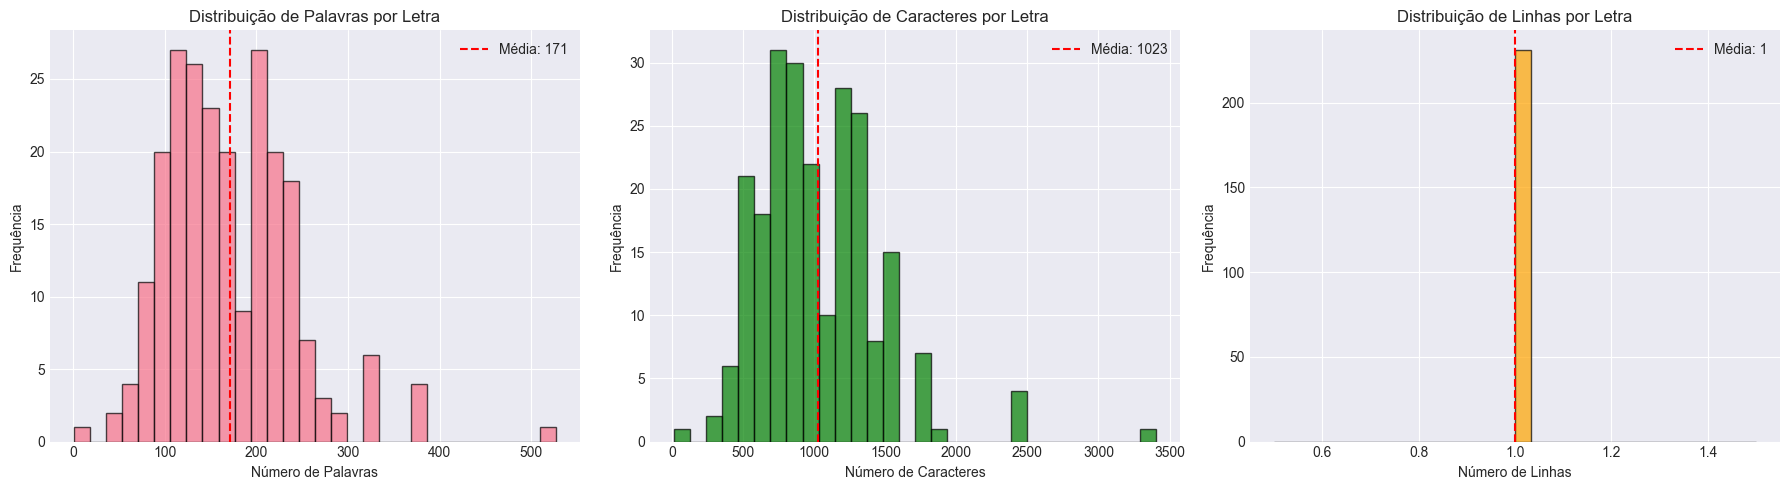

✓ Gráfico salvo como 'distribuicao_estatisticas_letras.png'


In [10]:
# Visualização das distribuições
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribuição de palavras
axes[0].hist(df_letras['Num_Palavras'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Número de Palavras')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Palavras por Letra')
axes[0].axvline(df_letras['Num_Palavras'].mean(), color='red', linestyle='--', label=f'Média: {df_letras["Num_Palavras"].mean():.0f}')
axes[0].legend()

# Distribuição de caracteres
axes[1].hist(df_letras['Num_Caracteres'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Número de Caracteres')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição de Caracteres por Letra')
axes[1].axvline(df_letras['Num_Caracteres'].mean(), color='red', linestyle='--', label=f'Média: {df_letras["Num_Caracteres"].mean():.0f}')
axes[1].legend()

# Distribuição de linhas
axes[2].hist(df_letras['Num_Linhas'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel('Número de Linhas')
axes[2].set_ylabel('Frequência')
axes[2].set_title('Distribuição de Linhas por Letra')
axes[2].axvline(df_letras['Num_Linhas'].mean(), color='red', linestyle='--', label=f'Média: {df_letras["Num_Linhas"].mean():.0f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('distribuicao_estatisticas_letras.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo como 'distribuicao_estatisticas_letras.png'")

In [11]:
# Análise de palavras mais frequentes
from collections import Counter
import string

# Juntar todas as letras
todas_letras = ' '.join(df_letras['Letra_Limpa'].values)

# Tokenizar e limpar
palavras = todas_letras.lower().split()
palavras = [palavra.strip(string.punctuation) for palavra in palavras]
palavras = [palavra for palavra in palavras if len(palavra) > 2]  # Remover palavras muito curtas

# Contar frequências
freq_palavras = Counter(palavras)

# Top 20 palavras mais frequentes
top_20 = freq_palavras.most_common(20)

print("Top 20 palavras mais frequentes:")
for i, (palavra, freq) in enumerate(top_20, 1):
    print(f"{i:2d}. {palavra:15s} - {freq:4d} ocorrências")

Top 20 palavras mais frequentes:
 1. que             - 1358 ocorrências
 2. não             - 1027 ocorrências
 3. pra             -  304 ocorrências
 4. tudo            -  270 ocorrências
 5. você            -  268 ocorrências
 6. uma             -  247 ocorrências
 7. mais            -  246 ocorrências
 8. por             -  205 ocorrências
 9. nada            -  191 ocorrências
10. gente           -  188 ocorrências
11. sem             -  172 ocorrências
12. sempre          -  143 ocorrências
13. pop             -  141 ocorrências
14. muito           -  138 ocorrências
15. mundo           -  134 ocorrências
16. dia             -  129 ocorrências
17. nos             -  125 ocorrências
18. como            -  119 ocorrências
19. vida            -  109 ocorrências
20. com             -  108 ocorrências


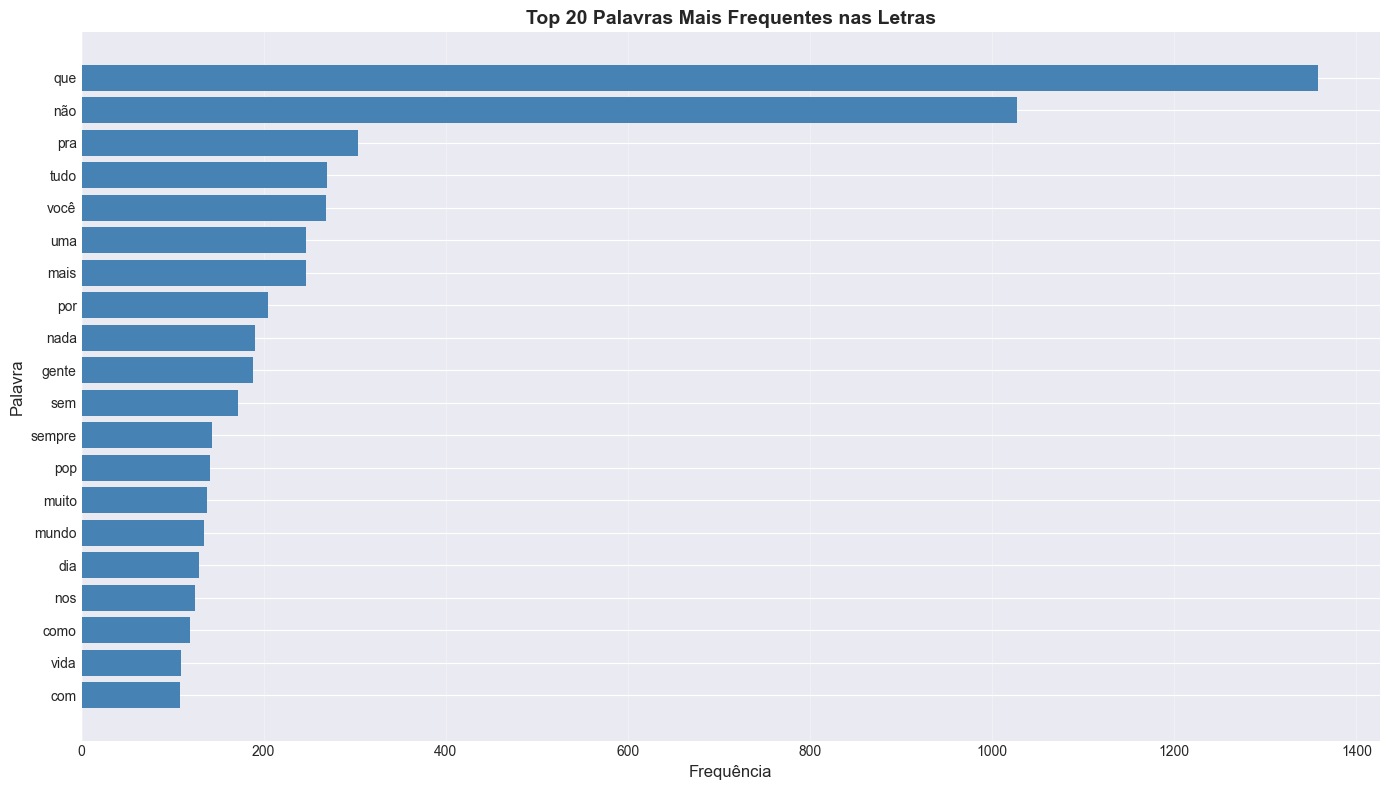

✓ Gráfico salvo como 'top20_palavras_frequentes_similaridade.png'


In [12]:
# Visualizar top 20 palavras
palavras_top, freqs_top = zip(*top_20)

plt.figure(figsize=(14, 8))
plt.barh(range(len(palavras_top)), freqs_top, color='steelblue')
plt.yticks(range(len(palavras_top)), palavras_top)
plt.xlabel('Frequência', fontsize=12)
plt.ylabel('Palavra', fontsize=12)
plt.title('Top 20 Palavras Mais Frequentes nas Letras', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top20_palavras_frequentes_similaridade.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo como 'top20_palavras_frequentes_similaridade.png'")

## Seção 4: Geração de Embeddings

Utilizando o modelo `sentence-transformers` para gerar embeddings semânticos das letras.

In [14]:
# Carregar modelo de sentence transformers
# Modelo multilíngue otimizado para português
print("Carregando modelo sentence-transformers...")
print("Modelo: paraphrase-multilingual-mpnet-base-v2")
print("Este processo pode levar alguns minutos na primeira vez...\n")

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

print("✓ Modelo carregado com sucesso!")
print(f"Dimensão dos embeddings: {model.get_sentence_embedding_dimension()}")

Carregando modelo sentence-transformers...
Modelo: paraphrase-multilingual-mpnet-base-v2
Este processo pode levar alguns minutos na primeira vez...

✓ Modelo carregado com sucesso!
Dimensão dos embeddings: 768


In [15]:
# Gerar embeddings para todas as letras
print("Gerando embeddings para todas as letras...")
print(f"Total de letras a processar: {len(df_letras)}\n")

# Converter letras para lista
letras_list = df_letras['Letra_Limpa'].tolist()

# Gerar embeddings em batch (mais eficiente)
embeddings = model.encode(letras_list, 
                         batch_size=32,
                         show_progress_bar=True,
                         convert_to_numpy=True)

print(f"\n✓ Embeddings gerados com sucesso!")
print(f"Shape dos embeddings: {embeddings.shape}")
print(f"({embeddings.shape[0]} músicas × {embeddings.shape[1]} dimensões)")

Gerando embeddings para todas as letras...
Total de letras a processar: 231



Batches:   0%|          | 0/8 [00:00<?, ?it/s]


✓ Embeddings gerados com sucesso!
Shape dos embeddings: (231, 768)
(231 músicas × 768 dimensões)


In [16]:
# Salvar embeddings para reutilização
import pickle

# Salvar embeddings
with open('embeddings_letras.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

# Salvar também o DataFrame com informações das músicas
df_letras.to_csv('letras_processadas.csv', index=False)

print("✓ Embeddings salvos em 'embeddings_letras.pkl'")
print("✓ Dataset processado salvo em 'letras_processadas.csv'")

✓ Embeddings salvos em 'embeddings_letras.pkl'
✓ Dataset processado salvo em 'letras_processadas.csv'


## Seção 5: Cálculo de Similaridade

Calculando a matriz de similaridade cosseno entre todas as músicas.

In [17]:
# Calcular matriz de similaridade cosseno
print("Calculando matriz de similaridade cosseno...")

similarity_matrix = cosine_similarity(embeddings)

print(f"✓ Matriz de similaridade calculada!")
print(f"Shape: {similarity_matrix.shape}")
print(f"\nEstatísticas da similaridade:")
print(f"- Mínimo: {similarity_matrix.min():.4f}")
print(f"- Máximo (excluindo diagonal): {np.max(similarity_matrix - np.eye(len(similarity_matrix))):.4f}")
print(f"- Média: {similarity_matrix.mean():.4f}")
print(f"- Mediana: {np.median(similarity_matrix):.4f}")

Calculando matriz de similaridade cosseno...
✓ Matriz de similaridade calculada!
Shape: (231, 231)

Estatísticas da similaridade:
- Mínimo: -0.0293
- Máximo (excluindo diagonal): 1.0000
- Média: 0.4614
- Mediana: 0.4605


In [18]:
# Criar DataFrame com a matriz de similaridade
df_similarity = pd.DataFrame(
    similarity_matrix,
    index=df_letras['Musica'].values,
    columns=df_letras['Musica'].values
)

# Salvar matriz de similaridade
df_similarity.to_csv('matriz_similaridade.csv')
print("✓ Matriz de similaridade salva em 'matriz_similaridade.csv'")

# Mostrar amostra da matriz
print("\nAmostra da matriz (5x5):")
df_similarity.iloc[:5, :5]

✓ Matriz de similaridade salva em 'matriz_similaridade.csv'

Amostra da matriz (5x5):


,Eu Que Não Amo Você,Negro Amor,Concreto e Asfalto,Até Mais,Nada Fácil
Eu Que Não Amo Você,1.000000,0.519538,0.461898,0.449511,0.422957
Negro Amor,0.519538,1.000000,0.667654,0.623913,0.655173
Concreto e Asfalto,0.461898,0.667654,1.000000,0.697069,0.546874
Até Mais,0.449511,0.623913,0.697069,1.000000,0.535482
Nada Fácil,0.422957,0.655173,0.546874,0.535482,1.000000


In [19]:
# Encontrar as músicas mais similares para cada canção
def encontrar_similares(musica_nome, top_n=5):
    """
    Encontra as músicas mais similares a uma dada música.
    
    Args:
        musica_nome: Nome da música
        top_n: Número de músicas similares a retornar
    
    Returns:
        DataFrame com músicas similares e scores
    """
    if musica_nome not in df_similarity.index:
        print(f"Música '{musica_nome}' não encontrada.")
        return None
    
    # Obter similaridades para a música
    similaridades = df_similarity[musica_nome].sort_values(ascending=False)
    
    # Remover a própria música (similaridade = 1.0)
    similaridades = similaridades[similaridades.index != musica_nome]
    
    # Retornar top N
    top_similares = similaridades.head(top_n)
    
    return pd.DataFrame({
        'Musica': top_similares.index,
        'Similaridade': top_similares.values
    })

# Testar com uma música famosa
musica_teste = df_letras['Musica'].iloc[0]
print(f"Músicas mais similares a '{musica_teste}':")
print(encontrar_similares(musica_teste, top_n=10))

Músicas mais similares a 'Eu Que Não Amo Você':
                    Musica  Similaridade
0      Eu que Não Amo Você      1.000000
1                Piano Bar      0.593581
2  Piano Baru00a0(Ao Vivo)      0.593581
3      Piano Bar (Ao Vivo)      0.593581
4             Sob O Tapete      0.587030
5             Sob o Tapete      0.587030
6             Sem Problema      0.575591
7                Até o Fim      0.562417
8                Até O Fim      0.562417
9                Faz Parte      0.561454


In [20]:
# Criar ranking dos pares de músicas mais similares
print("Calculando top 20 pares de músicas mais similares...\n")

# Extrair triângulo superior da matriz (evitar duplicatas)
pairs = []
n_songs = len(df_letras)

for i in range(n_songs):
    for j in range(i+1, n_songs):
        pairs.append({
            'Musica_1': df_letras['Musica'].iloc[i],
            'Musica_2': df_letras['Musica'].iloc[j],
            'Album_1': df_letras['Album'].iloc[i],
            'Album_2': df_letras['Album'].iloc[j],
            'Similaridade': similarity_matrix[i, j]
        })

df_pairs = pd.DataFrame(pairs)
df_pairs = df_pairs.sort_values('Similaridade', ascending=False)

# Top 20 pares
top_20_pairs = df_pairs.head(20)

# Salvar
top_20_pairs.to_csv('top20_pares_similares.csv', index=False)
print("✓ Top 20 pares salvos em 'top20_pares_similares.csv'\n")

print("Top 20 Pares de Músicas Mais Similares:")
print("="*80)
for idx, row in top_20_pairs.iterrows():
    print(f"{row['Musica_1']:40s} ↔ {row['Musica_2']:40s}")
    print(f"Similaridade: {row['Similaridade']:.4f}")
    print("-"*80)

Calculando top 20 pares de músicas mais similares...

✓ Top 20 pares salvos em 'top20_pares_similares.csv'

Top 20 Pares de Músicas Mais Similares:
Vida Real                                ↔ Vida Real (Ao Vivo)                     
Similaridade: 1.0000
--------------------------------------------------------------------------------
Concreto e Asfalto                       ↔ Concreto E Asfalto                      
Similaridade: 1.0000
--------------------------------------------------------------------------------
Luz                                      ↔ Luz (Ao Vivo)                           
Similaridade: 1.0000
--------------------------------------------------------------------------------
Até o Fim                                ↔ Até O Fim                               
Similaridade: 1.0000
--------------------------------------------------------------------------------
A Montanha                               ↔ A Montanha (Ao Vivo)                    
Similaridade: 1.0000
---

## Seção 6: Visualizações

Criando visualizações para interpretar os resultados.

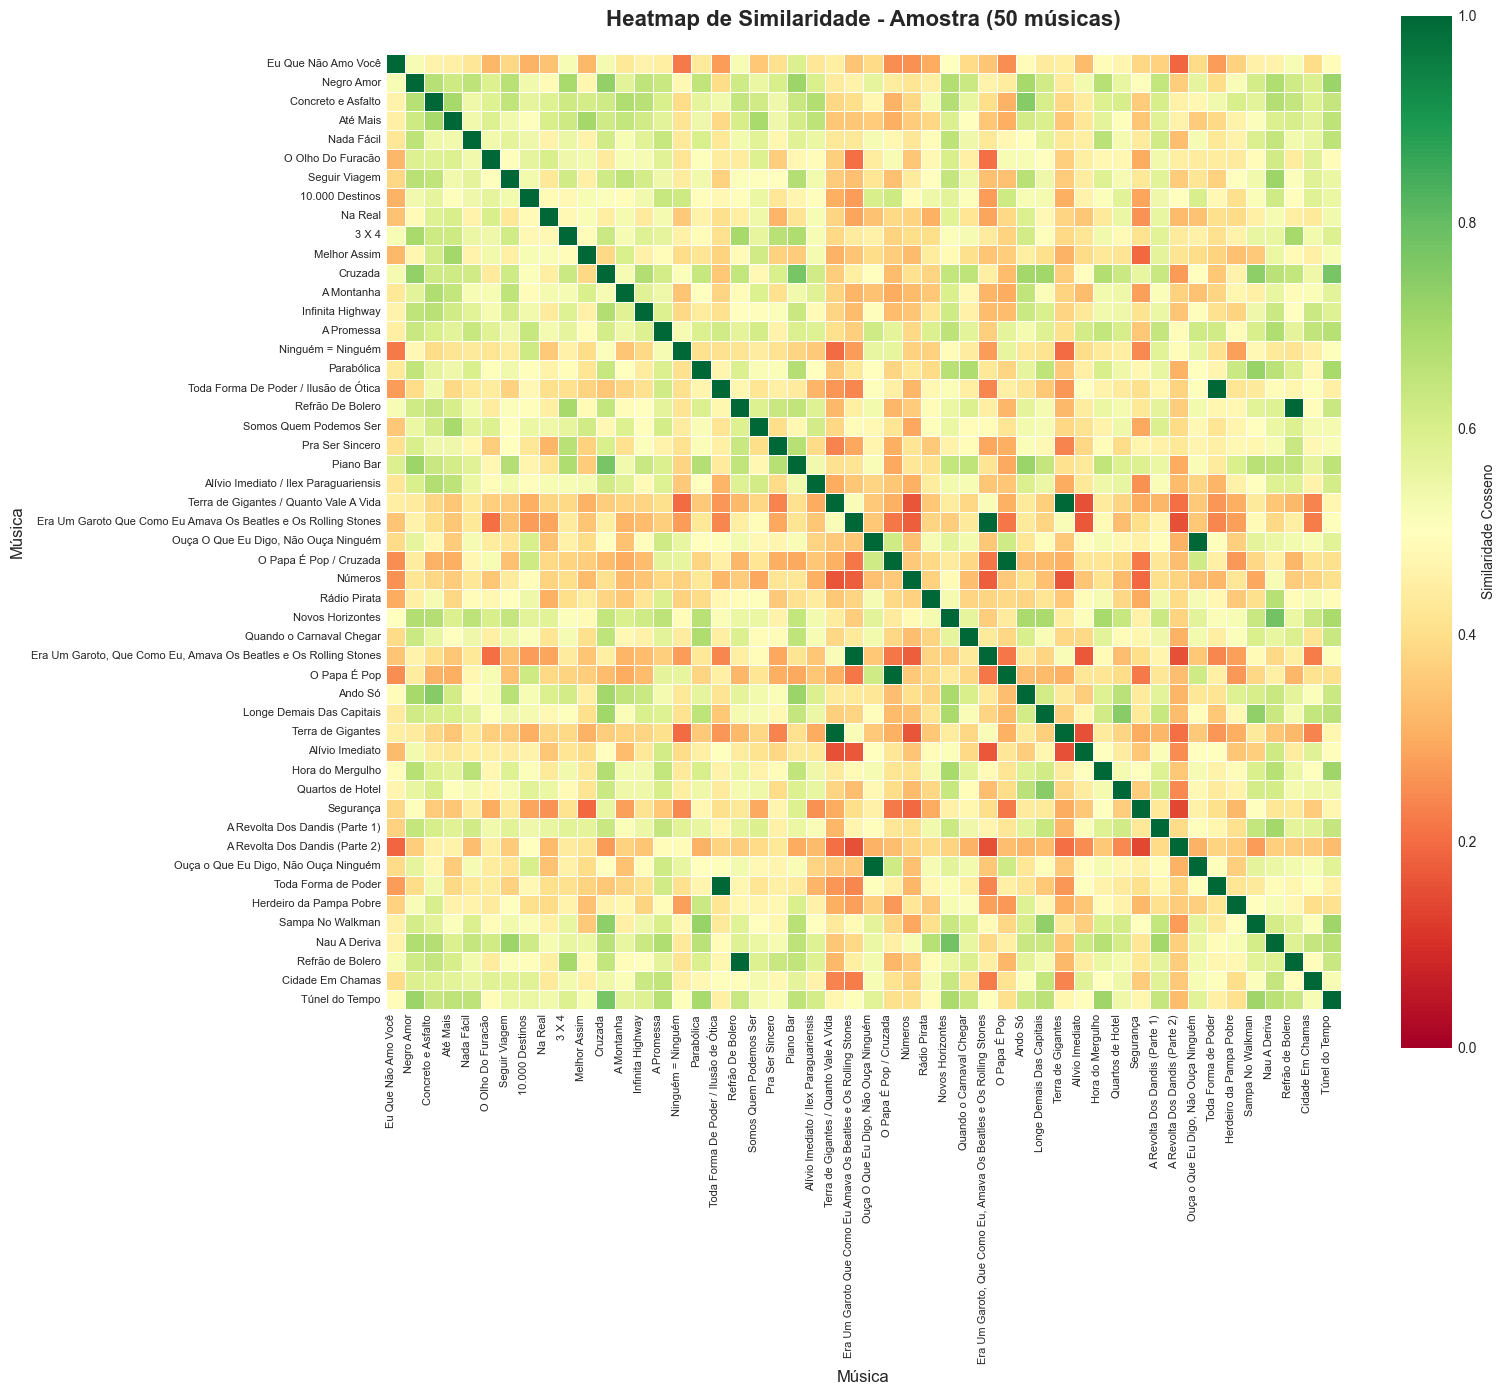

✓ Heatmap salvo como 'heatmap_similaridade_amostra.png'


In [21]:
# Heatmap da matriz de similaridade (amostra)
# Mostrar apenas as primeiras 50 músicas para legibilidade
n_sample = min(50, len(df_letras))

plt.figure(figsize=(16, 14))
sns.heatmap(similarity_matrix[:n_sample, :n_sample],
            xticklabels=df_letras['Musica'].iloc[:n_sample].values,
            yticklabels=df_letras['Musica'].iloc[:n_sample].values,
            cmap='RdYlGn',
            center=0.5,
            vmin=0,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Similaridade Cosseno'})

plt.title(f'Heatmap de Similaridade - Amostra ({n_sample} músicas)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Música', fontsize=12)
plt.ylabel('Música', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('heatmap_similaridade_amostra.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Heatmap salvo como 'heatmap_similaridade_amostra.png'")

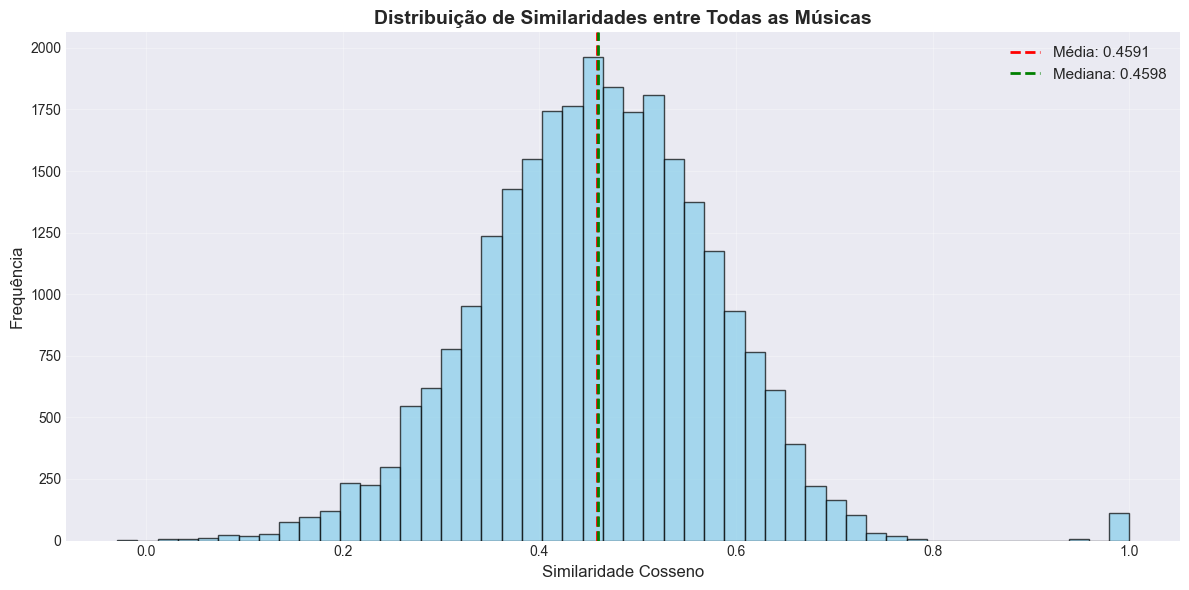

✓ Distribuição salva como 'distribuicao_similaridades.png'


In [22]:
# Distribuição de similaridades
# Pegar triângulo superior (sem diagonal)
triu_indices = np.triu_indices_from(similarity_matrix, k=1)
similarities_upper = similarity_matrix[triu_indices]

plt.figure(figsize=(12, 6))
plt.hist(similarities_upper, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(similarities_upper.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Média: {similarities_upper.mean():.4f}')
plt.axvline(np.median(similarities_upper), color='green', linestyle='--', 
           linewidth=2, label=f'Mediana: {np.median(similarities_upper):.4f}')
plt.xlabel('Similaridade Cosseno', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição de Similaridades entre Todas as Músicas', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('distribuicao_similaridades.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribuição salva como 'distribuicao_similaridades.png'")

In [23]:
# Redução dimensional com UMAP ou t-SNE
print("Realizando redução dimensional para visualização 2D...")

if UMAP_AVAILABLE:
    print("Usando UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_2d = reducer.fit_transform(embeddings)
else:
    print("Usando t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

# Adicionar coordenadas ao DataFrame
df_letras['x'] = embeddings_2d[:, 0]
df_letras['y'] = embeddings_2d[:, 1]

print("✓ Redução dimensional concluída!")

Realizando redução dimensional para visualização 2D...
Usando UMAP...
✓ Redução dimensional concluída!


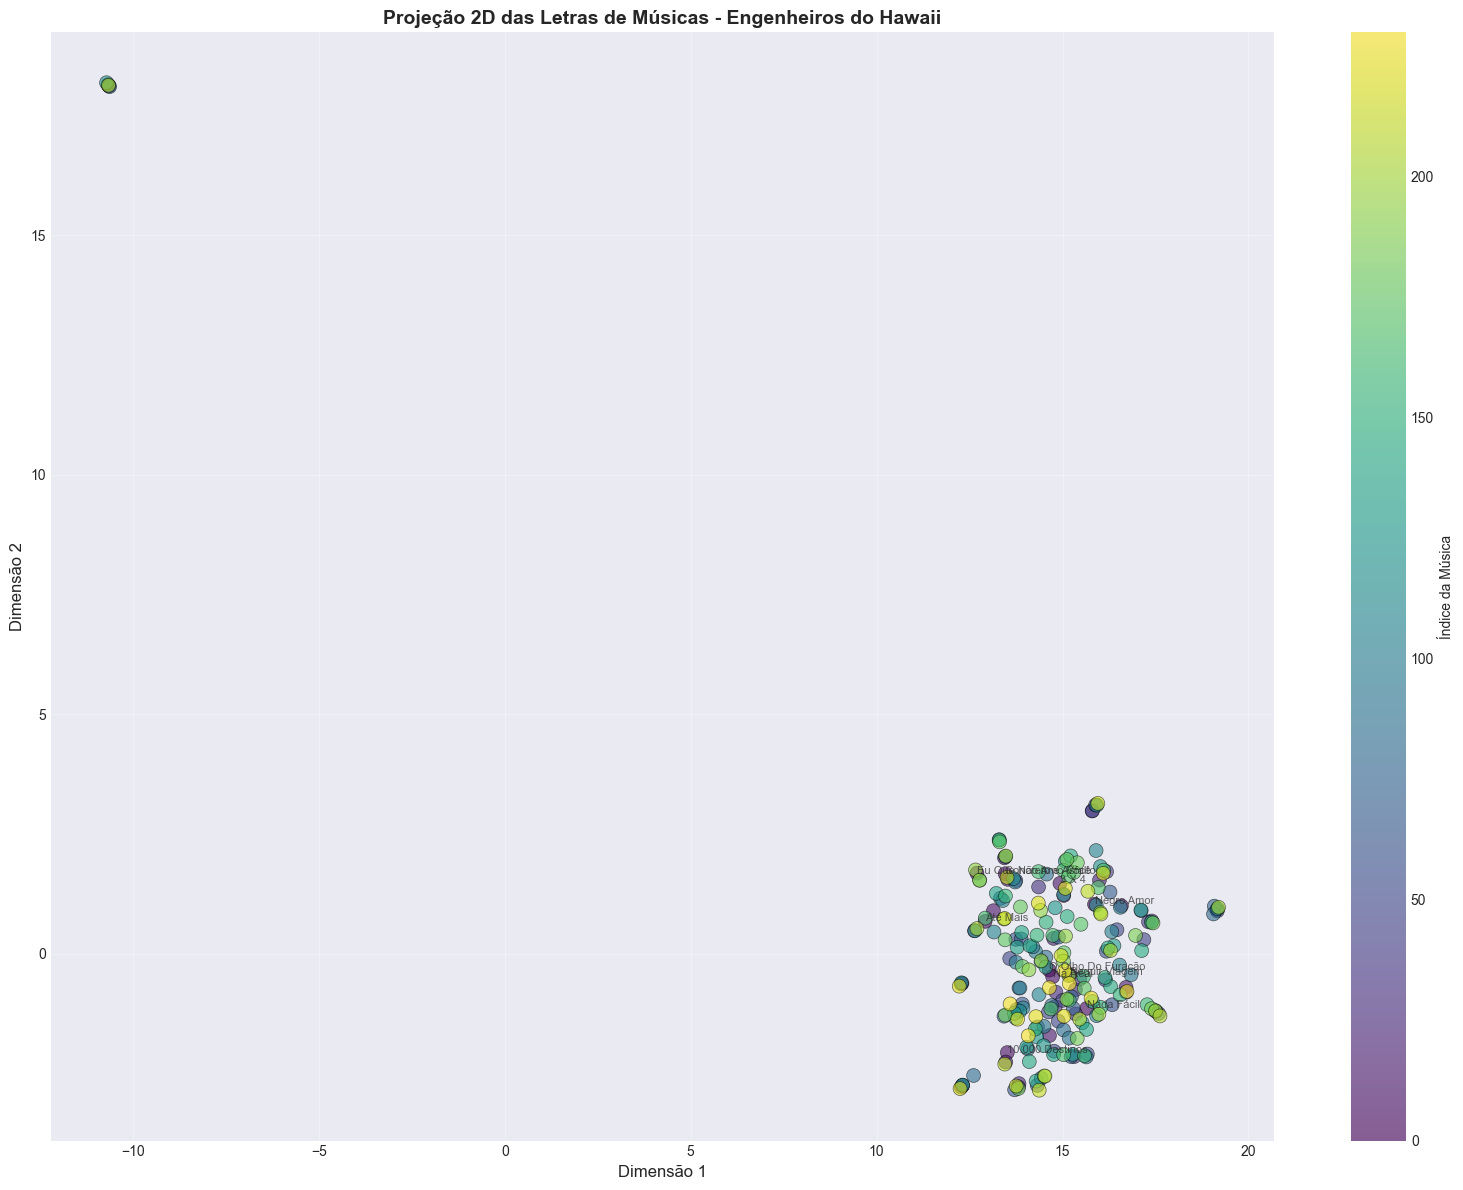

✓ Scatter plot salvo como 'scatter_2d_letras.png'


In [24]:
# Scatter plot 2D das músicas
plt.figure(figsize=(16, 12))
scatter = plt.scatter(df_letras['x'], df_letras['y'], 
                     c=range(len(df_letras)),
                     cmap='viridis',
                     alpha=0.6,
                     s=100,
                     edgecolors='black',
                     linewidth=0.5)

plt.colorbar(scatter, label='Índice da Música')
plt.xlabel('Dimensão 1', fontsize=12)
plt.ylabel('Dimensão 2', fontsize=12)
plt.title('Projeção 2D das Letras de Músicas - Engenheiros do Hawaii', 
         fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Anotar algumas músicas (top 10 para não poluir)
for idx in range(min(10, len(df_letras))):
    plt.annotate(df_letras['Musica'].iloc[idx][:20], 
                (df_letras['x'].iloc[idx], df_letras['y'].iloc[idx]),
                fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('scatter_2d_letras.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Scatter plot salvo como 'scatter_2d_letras.png'")

In [25]:
# Visualização interativa com Plotly
fig = px.scatter(df_letras, 
                x='x', 
                y='y',
                hover_data=['Musica', 'Album', 'Num_Palavras'],
                color='Album',
                title='Mapa Interativo de Similaridade - Engenheiros do Hawaii',
                labels={'x': 'Dimensão 1', 'y': 'Dimensão 2'},
                width=1200,
                height=800)

fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(font=dict(size=11))

# Salvar como HTML interativo
fig.write_html('mapa_interativo_similaridade.html')
print("✓ Mapa interativo salvo como 'mapa_interativo_similaridade.html'")

fig.show()

✓ Mapa interativo salvo como 'mapa_interativo_similaridade.html'


Criando network graph...
Nós: 231
Arestas (similaridade >= 0.75): 147


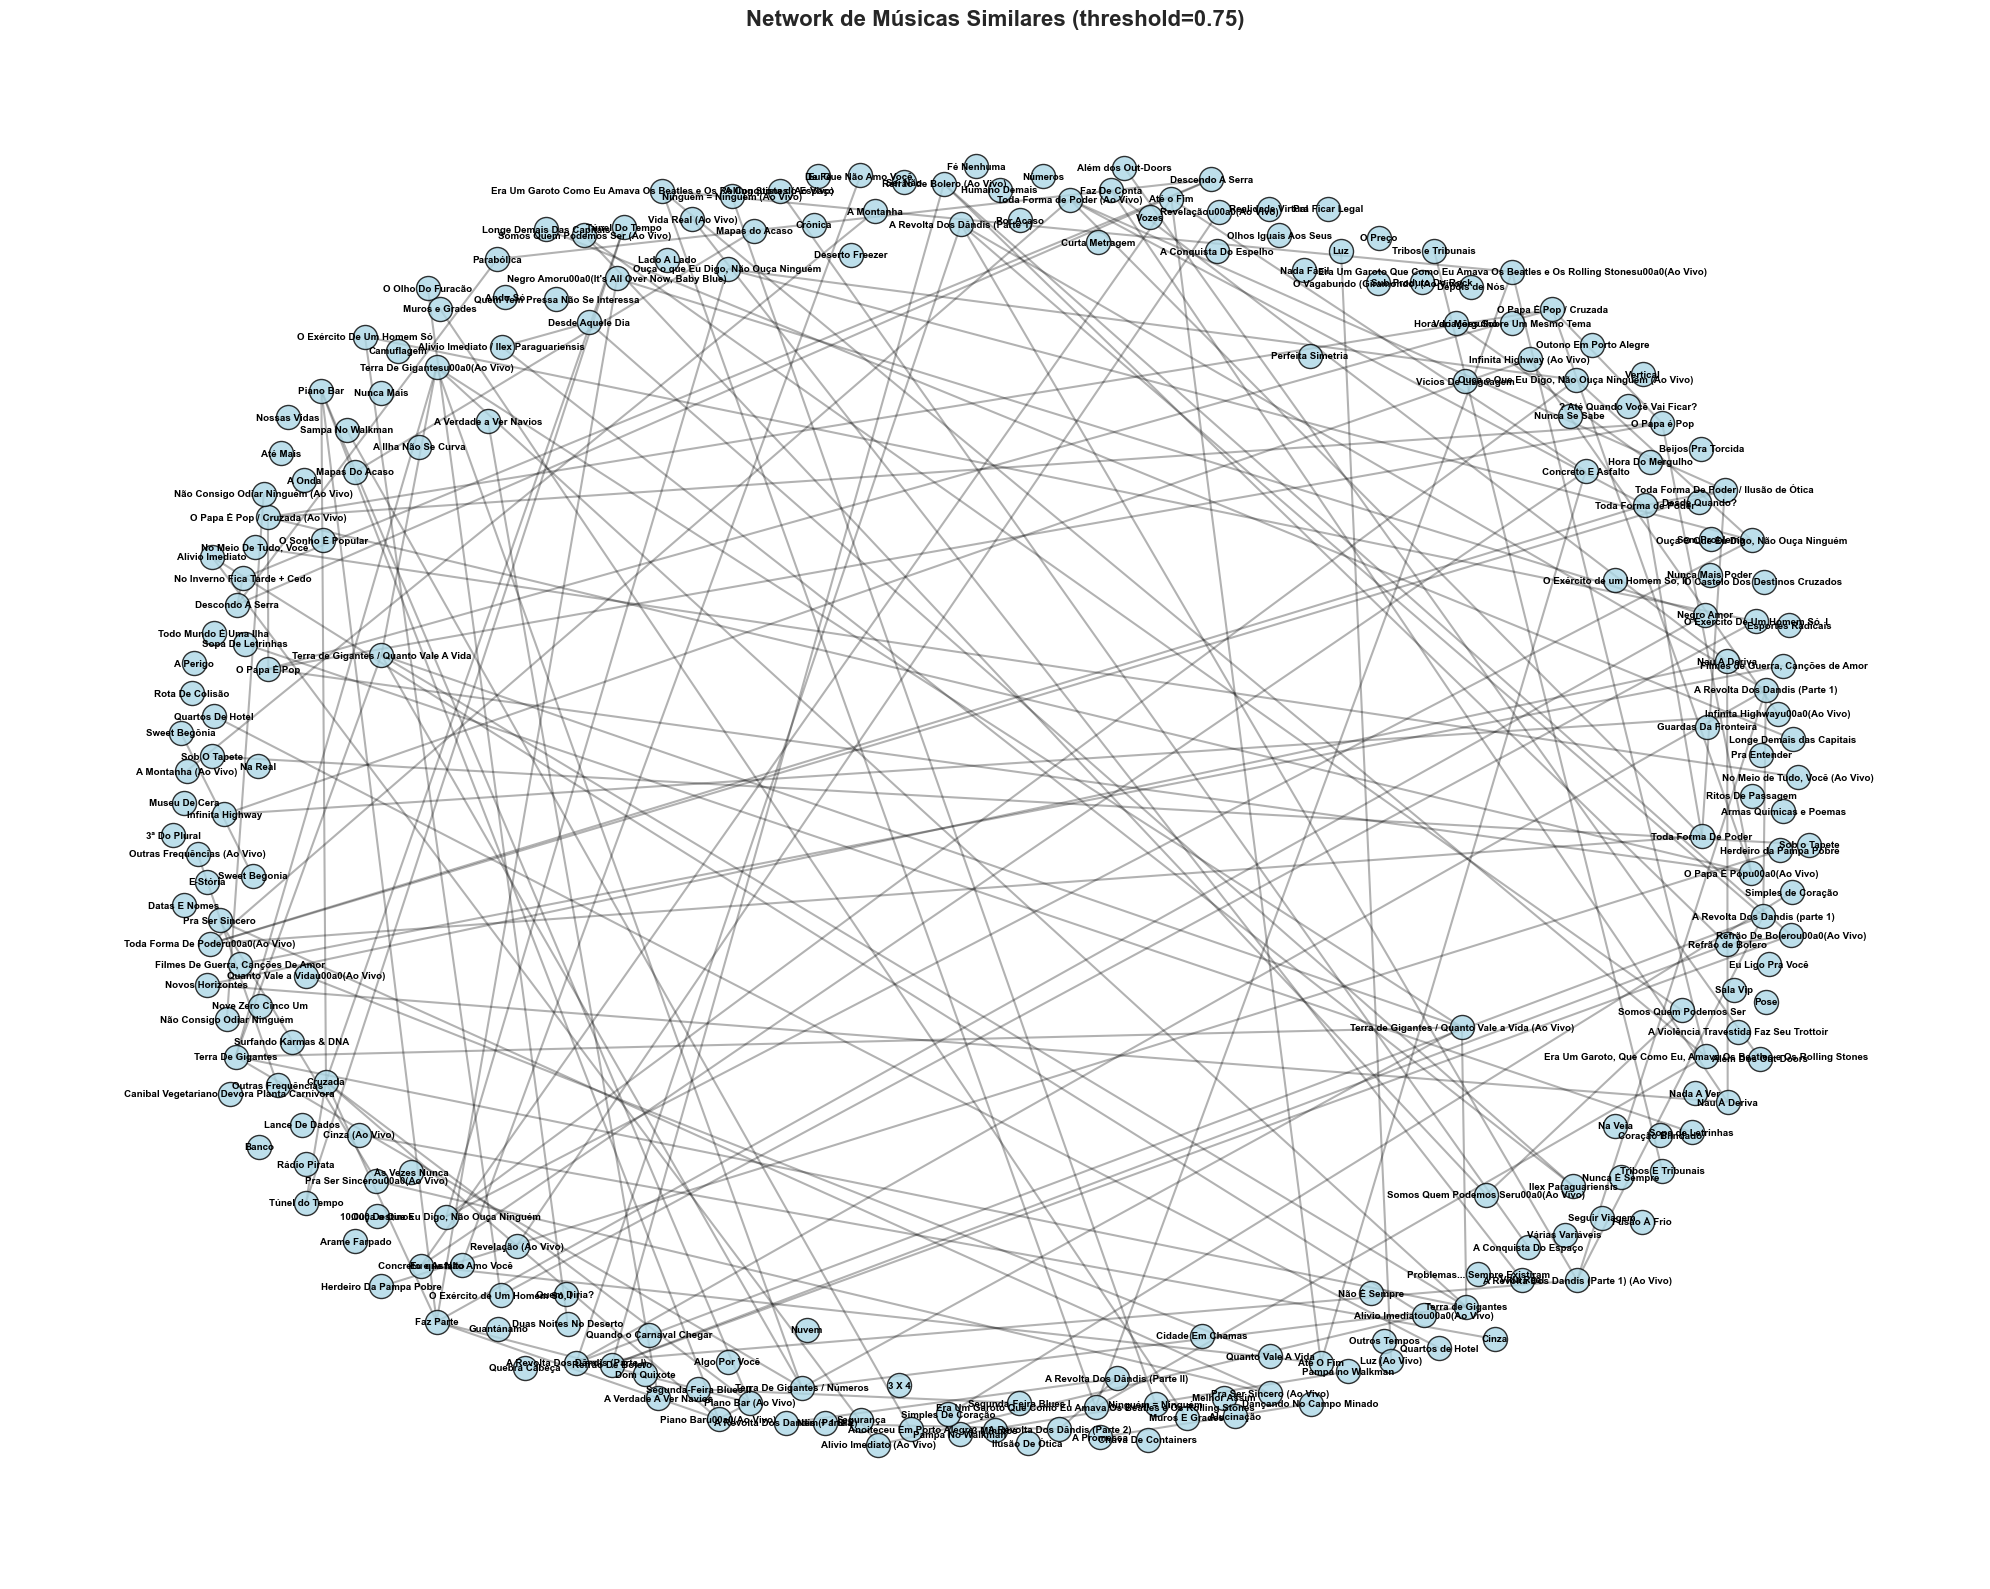

✓ Network graph salvo como 'network_similaridade.png'


In [26]:
# Network graph das músicas mais similares
if NETWORKX_AVAILABLE:
    print("Criando network graph...")
    
    # Criar grafo
    G = nx.Graph()
    
    # Adicionar nós (músicas)
    for musica in df_letras['Musica'].values:
        G.add_node(musica)
    
    # Adicionar arestas (similaridade > threshold)
    threshold = 0.75  # Apenas músicas muito similares
    
    for i in range(len(df_letras)):
        for j in range(i+1, len(df_letras)):
            sim = similarity_matrix[i, j]
            if sim >= threshold:
                G.add_edge(df_letras['Musica'].iloc[i], 
                          df_letras['Musica'].iloc[j],
                          weight=sim)
    
    print(f"Nós: {G.number_of_nodes()}")
    print(f"Arestas (similaridade >= {threshold}): {G.number_of_edges()}")
    
    if G.number_of_edges() > 0:
        # Visualizar
        plt.figure(figsize=(20, 16))
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        # Desenhar
        nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', 
                              alpha=0.8, edgecolors='black', linewidths=1)
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.5)
        nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold')
        
        plt.title(f'Network de Músicas Similares (threshold={threshold})', 
                 fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('network_similaridade.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Network graph salvo como 'network_similaridade.png'")
    else:
        print(f"Nenhuma conexão encontrada com threshold {threshold}. "
              f"Tente diminuir o threshold.")
else:
    print("NetworkX não disponível. Pulando visualização de rede.")

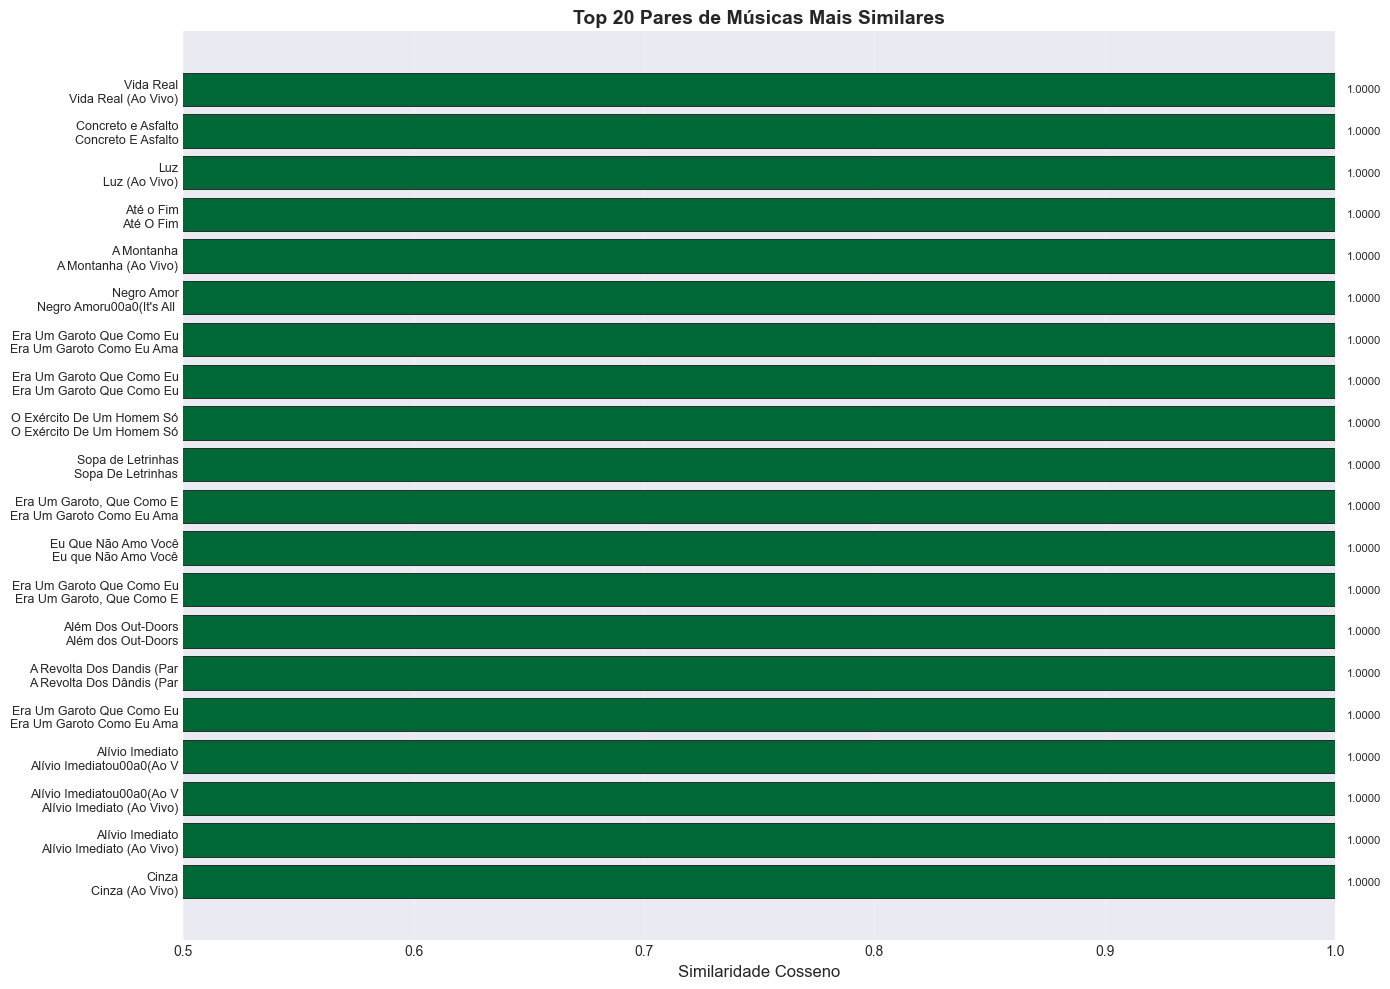

✓ Visualização salva como 'top20_pares_similares_viz.png'


In [27]:
# Visualizar top 20 pares mais similares
fig, ax = plt.subplots(figsize=(14, 10))

# Criar labels para os pares
labels = [f"{row['Musica_1'][:25]}\n{row['Musica_2'][:25]}" 
         for _, row in top_20_pairs.iterrows()]
similarities = top_20_pairs['Similaridade'].values

# Criar barplot horizontal
colors = plt.cm.RdYlGn(similarities)
y_pos = np.arange(len(labels))

ax.barh(y_pos, similarities, color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Similaridade Cosseno', fontsize=12)
ax.set_title('Top 20 Pares de Músicas Mais Similares', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.set_xlim([0.5, 1.0])
ax.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(similarities):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('top20_pares_similares_viz.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualização salva como 'top20_pares_similares_viz.png'")

## Seção 7: Análise de Clusters

Identificando grupos temáticos de músicas usando clustering.

Calculando número ótimo de clusters (método do cotovelo)...


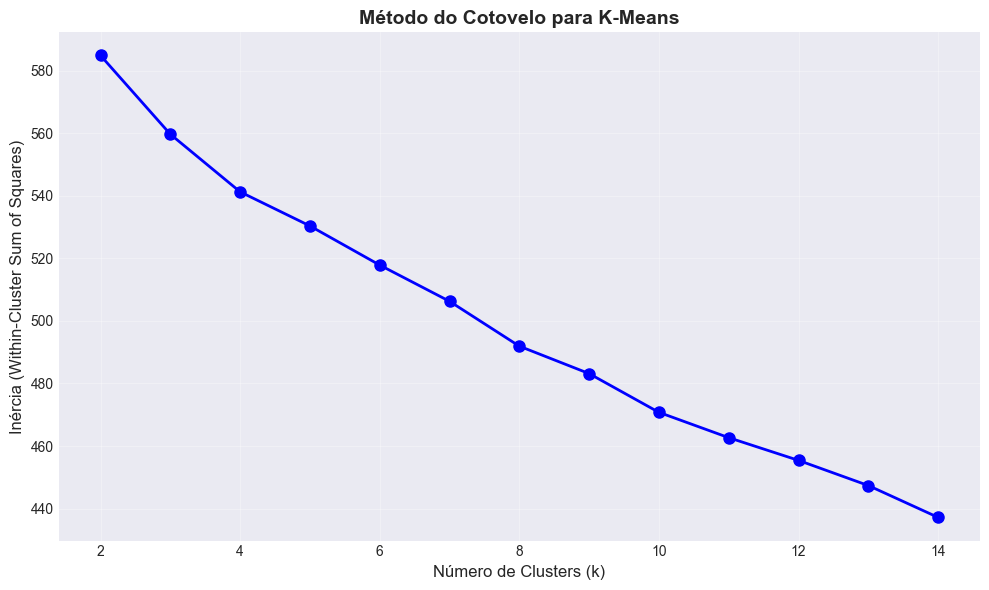

✓ Gráfico salvo como 'metodo_cotovelo.png'

Analise o gráfico para determinar o número ideal de clusters (ponto do 'cotovelo')


In [28]:
# Método do cotovelo para determinar número ótimo de clusters
print("Calculando número ótimo de clusters (método do cotovelo)...")

inertias = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

# Plotar curva do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Método do Cotovelo para K-Means', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('metodo_cotovelo.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico salvo como 'metodo_cotovelo.png'")
print("\nAnalise o gráfico para determinar o número ideal de clusters (ponto do 'cotovelo')")

In [29]:
# Aplicar K-Means com número escolhido de clusters
# Baseado na análise do cotovelo, escolhemos um número razoável
n_clusters = 6  # Ajuste conforme necessário

print(f"Aplicando K-Means com {n_clusters} clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_letras['Cluster_KMeans'] = kmeans.fit_predict(embeddings)

print("✓ Clustering concluído!")
print(f"\nDistribuição de músicas por cluster:")
print(df_letras['Cluster_KMeans'].value_counts().sort_index())

Aplicando K-Means com 6 clusters...
✓ Clustering concluído!

Distribuição de músicas por cluster:
Cluster_KMeans
0    10
1    72
2    12
3    15
4    51
5    71
Name: count, dtype: int64


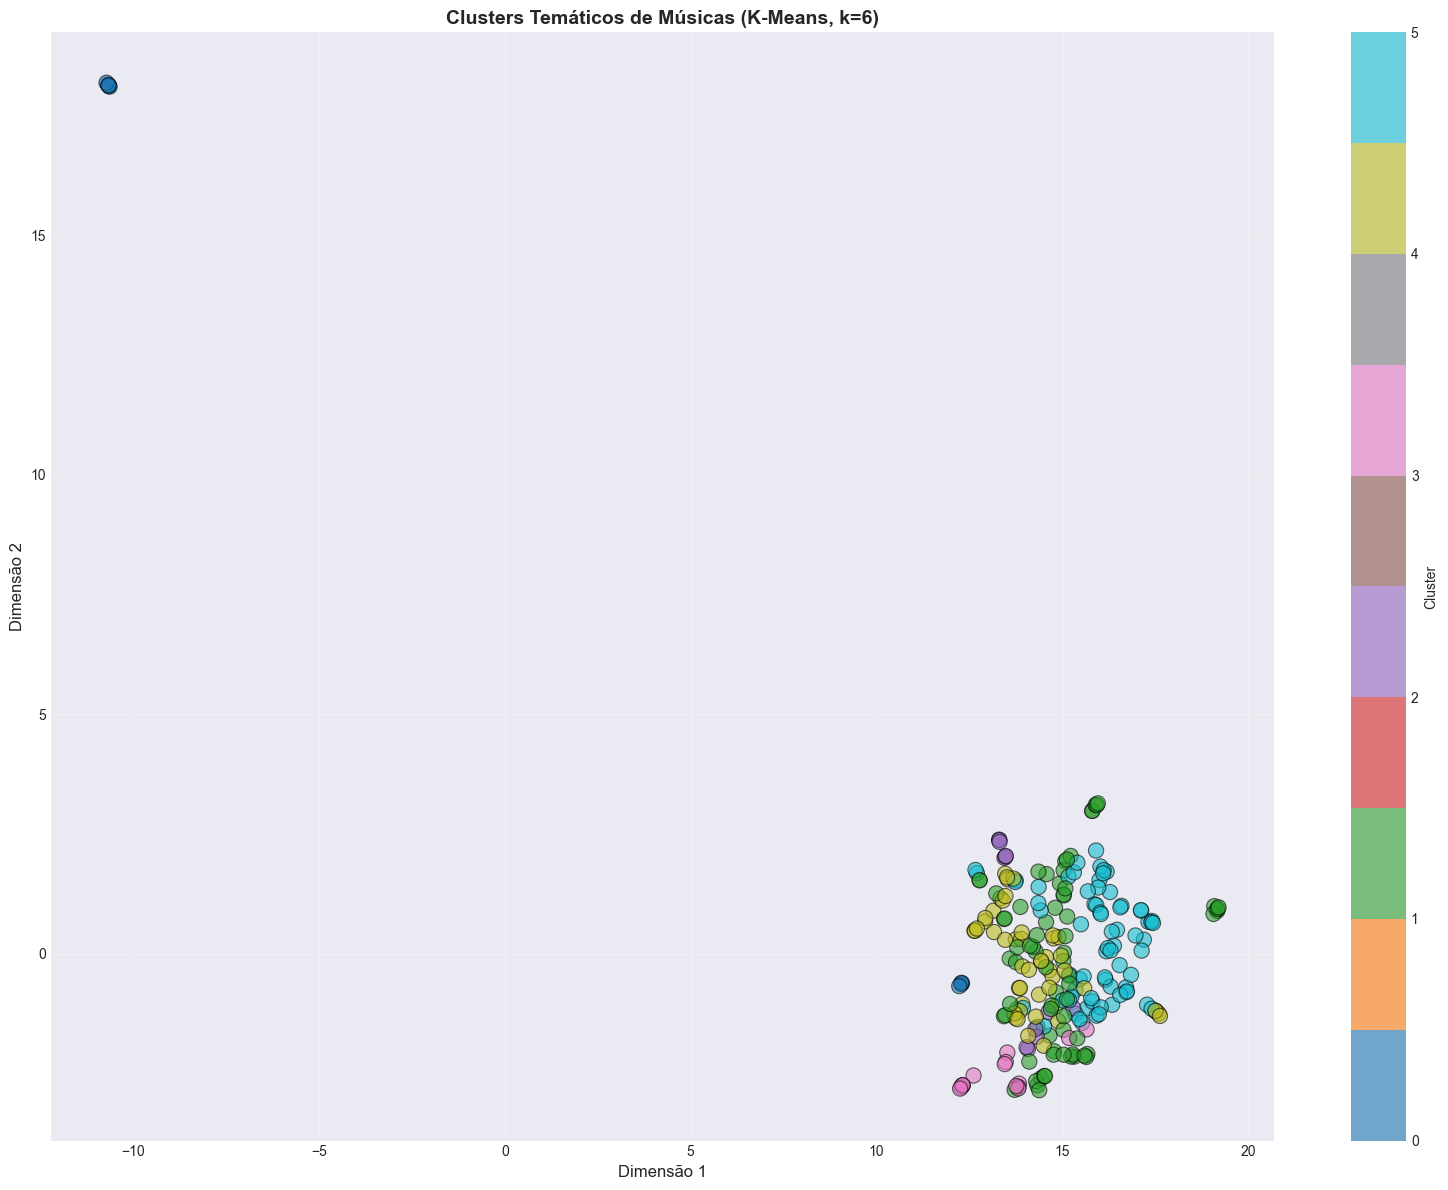

✓ Visualização de clusters salva como 'clusters_kmeans_2d.png'


In [30]:
# Visualizar clusters no espaço 2D
plt.figure(figsize=(16, 12))
scatter = plt.scatter(df_letras['x'], df_letras['y'], 
                     c=df_letras['Cluster_KMeans'],
                     cmap='tab10',
                     alpha=0.6,
                     s=120,
                     edgecolors='black',
                     linewidth=0.8)

plt.colorbar(scatter, label='Cluster', ticks=range(n_clusters))
plt.xlabel('Dimensão 1', fontsize=12)
plt.ylabel('Dimensão 2', fontsize=12)
plt.title(f'Clusters Temáticos de Músicas (K-Means, k={n_clusters})', 
         fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('clusters_kmeans_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualização de clusters salva como 'clusters_kmeans_2d.png'")

In [31]:
# Visualização interativa dos clusters
fig = px.scatter(df_letras,
                x='x',
                y='y',
                color='Cluster_KMeans',
                hover_data=['Musica', 'Album', 'Num_Palavras'],
                title=f'Clusters Temáticos Interativos (K-Means, k={n_clusters})',
                labels={'x': 'Dimensão 1', 'y': 'Dimensão 2', 'Cluster_KMeans': 'Cluster'},
                color_continuous_scale='Viridis',
                width=1200,
                height=800)

fig.update_traces(marker=dict(size=10, line=dict(width=0.8, color='DarkSlateGrey')))

fig.write_html('clusters_interativos.html')
print("✓ Visualização interativa salva como 'clusters_interativos.html'")

fig.show()

✓ Visualização interativa salva como 'clusters_interativos.html'


In [32]:
# Analisar características de cada cluster
print("Análise Detalhada dos Clusters")
print("="*100)

for cluster_id in range(n_clusters):
    cluster_songs = df_letras[df_letras['Cluster_KMeans'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id}")
    print("-"*100)
    print(f"Número de músicas: {len(cluster_songs)}")
    print(f"Média de palavras por letra: {cluster_songs['Num_Palavras'].mean():.1f}")
    print(f"Álbuns mais representados:")
    print(cluster_songs['Album'].value_counts().head(3))
    
    print(f"\nAlgumas músicas deste cluster:")
    for i, musica in enumerate(cluster_songs['Musica'].head(5), 1):
        print(f"  {i}. {musica}")
    
    if len(cluster_songs) > 5:
        print(f"  ... e mais {len(cluster_songs) - 5} músicas")

Análise Detalhada dos Clusters

CLUSTER 0
----------------------------------------------------------------------------------------------------
Número de músicas: 10
Média de palavras por letra: 220.1
Álbuns mais representados:
Album
10.000_Destinos_(Ao_Vivo)    2
100_Anos_de_Música           2
Sem_Limite                   2
Name: count, dtype: int64

Algumas músicas deste cluster:
  1. Terra de Gigantes / Quanto Vale A Vida
  2. Era Um Garoto Que Como Eu Amava Os Beatles e Os Rolling Stones
  3. Era Um Garoto, Que Como Eu, Amava Os Beatles e Os Rolling Stones
  4. Terra de Gigantes
  5. Terra De Gigantes / Números
  ... e mais 5 músicas

CLUSTER 1
----------------------------------------------------------------------------------------------------
Número de músicas: 72
Média de palavras por letra: 172.6
Álbuns mais representados:
Album
Infinita_Highway                          22
Novos_Horizontes_(Acústico)_(Ao_Vivo)_     6
Sem_Limite                                 6
Name: count, dtype

In [ ]:
# Identificar palavras-chave por cluster
from collections import Counter
import string

print("\nPalavras-chave mais frequentes por cluster:")
print("="*100)

# Stopwords básicas em português
stopwords_pt = {'de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 
               'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como',
               'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser',
               'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo',
               'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo',
               'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você',
               'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha',
               'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós',
               'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse',
               'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu',
               'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela',
               'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles',
               'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão',
               'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos',
               'estavam', 'estivera', 'estivéramos', 'seja', 'sejamos', 'sejam',
               'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'sou', 'somos',
               'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora',
               'fôramos', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos',
               'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham',
               'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'terei',
               'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam'}

for cluster_id in range(n_clusters):
    cluster_songs = df_letras[df_letras['Cluster_KMeans'] == cluster_id]
    
    # Juntar todas as letras do cluster
    cluster_text = ' '.join(cluster_songs['Letra_Limpa'].values)
    
    # Tokenizar e limpar
    palavras = cluster_text.lower().split()
    palavras = [p.strip(string.punctuation) for p in palavras]
    palavras = [p for p in palavras if len(p) > 3 and p not in stopwords_pt]
    
    # Contar frequências
    freq = Counter(palavras)
    top_10 = freq.most_common(10)
    
    print(f"\nCLUSTER {cluster_id} - Top 10 palavras:")
    for palavra, count in top_10:
        print(f"  {palavra:15s} ({count:3d})")

In [ ]:
# Salvar análise de clusters em arquivo
cluster_analysis = []

for cluster_id in range(n_clusters):
    cluster_songs = df_letras[df_letras['Cluster_KMeans'] == cluster_id]
    
    for _, song in cluster_songs.iterrows():
        cluster_analysis.append({
            'Cluster': cluster_id,
            'Musica': song['Musica'],
            'Album': song['Album'],
            'Num_Palavras': song['Num_Palavras'],
            'Num_Caracteres': song['Num_Caracteres']
        })

df_cluster_analysis = pd.DataFrame(cluster_analysis)
df_cluster_analysis.to_csv('analise_clusters.csv', index=False)

print("\n✓ Análise de clusters salva em 'analise_clusters.csv'")

## Seção 8: Insights e Conclusões

Resumo dos principais achados da análise.

In [ ]:
# Gerar relatório final
print("="*100)
print(" "*35 + "RELATÓRIO FINAL DE ANÁLISE")
print("="*100)

print("\n1. ESTATÍSTICAS GERAIS")
print("-"*100)
print(f"   Total de músicas analisadas: {len(df_letras)}")
print(f"   Total de álbuns: {df_letras['Album'].nunique()}")
print(f"   Média de palavras por letra: {df_letras['Num_Palavras'].mean():.1f}")
print(f"   Média de caracteres por letra: {df_letras['Num_Caracteres'].mean():.1f}")

print("\n2. SIMILARIDADE")
print("-"*100)
print(f"   Similaridade média entre músicas: {similarities_upper.mean():.4f}")
print(f"   Similaridade mediana: {np.median(similarities_upper):.4f}")
print(f"   Similaridade máxima encontrada: {similarities_upper.max():.4f}")
print(f"   Similaridade mínima encontrada: {similarities_upper.min():.4f}")

print("\n3. PAR MAIS SIMILAR")
print("-"*100)
most_similar = top_20_pairs.iloc[0]
print(f"   Música 1: {most_similar['Musica_1']}")
print(f"   Música 2: {most_similar['Musica_2']}")
print(f"   Similaridade: {most_similar['Similaridade']:.4f}")

print("\n4. CLUSTERS IDENTIFICADOS")
print("-"*100)
print(f"   Número de clusters: {n_clusters}")
print(f"   Distribuição:")
for cluster_id in range(n_clusters):
    count = len(df_letras[df_letras['Cluster_KMeans'] == cluster_id])
    percentage = (count / len(df_letras)) * 100
    print(f"      Cluster {cluster_id}: {count:3d} músicas ({percentage:5.1f}%)")

print("\n5. ARQUIVOS GERADOS")
print("-"*100)
print("   - matriz_similaridade.csv")
print("   - top20_pares_similares.csv")
print("   - analise_clusters.csv")
print("   - letras_processadas.csv")
print("   - embeddings_letras.pkl")
print("   - Diversos gráficos (.png)")
print("   - Visualizações interativas (.html)")

print("\n" + "="*100)
print(" "*30 + "ANÁLISE CONCLUÍDA COM SUCESSO!")
print("="*100)

In [ ]:
# Interpretação dos clusters (manual - ajuste conforme análise)
interpretacoes_clusters = {
    0: "Músicas sobre relacionamentos e sentimentos pessoais",
    1: "Crítica social e política",
    2: "Reflexões existenciais e filosóficas",
    3: "Vida urbana e cotidiano",
    4: "Amor e romance",
    5: "Nostalgia e memórias"
}

print("\nINTERPRETAÇÃO TEMÁTICA DOS CLUSTERS")
print("="*100)
print("\nNOTA: As interpretações abaixo são sugestões baseadas nas palavras-chave.")
print("Analise as músicas de cada cluster para validar e refinar estas categorias.\n")

for cluster_id in range(min(n_clusters, len(interpretacoes_clusters))):
    cluster_songs = df_letras[df_letras['Cluster_KMeans'] == cluster_id]
    print(f"Cluster {cluster_id}: {interpretacoes_clusters.get(cluster_id, 'Tema a identificar')}")
    print(f"  ({len(cluster_songs)} músicas)")
    print()

In [ ]:
# Sugestões para análises futuras
print("\nSUGESTÕES PARA ANÁLISES FUTURAS")
print("="*100)
print("""
1. ANÁLISE TEMPORAL
   - Investigar evolução temática ao longo dos álbuns
   - Identificar mudanças de estilo ao longo do tempo

2. ANÁLISE DE SENTIMENTOS
   - Aplicar modelos de análise de sentimento
   - Correlacionar sentimentos com clusters temáticos

3. TOPIC MODELING
   - Aplicar LDA (Latent Dirichlet Allocation)
   - Comparar tópicos identificados com clusters

4. ANÁLISE COMPARATIVA
   - Comparar com letras de outros artistas
   - Identificar características únicas dos Engenheiros do Hawaii

5. ANÁLISE DE RIMAS E ESTRUTURA
   - Identificar padrões de rima
   - Analisar estruturas métricas

6. WORD EMBEDDINGS ESPECÍFICOS
   - Treinar word2vec específico para as letras
   - Identificar relações semânticas únicas do artista

7. CLUSTERING HIERÁRQUICO
   - Explorar dendrogramas para hierarquia temática
   - Comparar com K-Means

8. ANÁLISE DE COOCORRÊNCIA
   - Identificar pares de palavras frequentes
   - Criar network de conceitos
""")

print("="*100)

## Documentação de Execução

### Como Executar Este Notebook

1. **Requisitos**:
   - Python 3.8+
   - Bibliotecas: pandas, numpy, sentence-transformers, sklearn, matplotlib, seaborn, plotly, beautifulsoup4
   - Opcional: umap-learn, networkx

2. **Instalação de Dependências**:
   ```bash
   pip install pandas numpy sentence-transformers scikit-learn matplotlib seaborn plotly beautifulsoup4
   pip install umap-learn networkx  # Opcional
   ```

3. **Estrutura de Arquivos**:
   - Certifique-se de que a pasta `letras_engenheiros_hawaii` está no mesmo diretório do notebook
   - Os arquivos CSV devem ter as colunas: `Musica`, `Letra`

4. **Execução**:
   - Execute as células sequencialmente (Shift + Enter)
   - Primeira execução baixará o modelo sentence-transformers (~500MB)
   - Tempo estimado: 5-15 minutos (depende do hardware)

5. **Saídas**:
   - CSVs: `matriz_similaridade.csv`, `top20_pares_similares.csv`, `analise_clusters.csv`
   - Gráficos: Diversos arquivos PNG
   - Interativos: Arquivos HTML
   - Modelo: `embeddings_letras.pkl`

6. **Personalização**:
   - Ajuste `n_clusters` para alterar número de grupos
   - Modifique threshold em network graph para mais/menos conexões
   - Adicione stopwords personalizadas conforme necessário

---

**Desenvolvido para análise de similaridade de letras dos Engenheiros do Hawaii**

**Data**: 2025

**Tecnologias**: Python, Sentence-Transformers, Scikit-learn, Plotly, Seaborn
